<a href="https://colab.research.google.com/github/textspur/prompting_open_llm/blob/main/Example_tweets_sentiment_zephyr_7b_alpha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

The script starts by downloading the necessary libraries.

In [ ]:
### Installation on Colab
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U safetensors
!pip install -q -U torch
!pip install -q -U xformers
!pip install -q -U langchain
!pip install wget

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu118 requires torch==2.1.0, but you have torch 2.1.1 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 2.1.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.1.1 which is incompatible.
torchvision 0.16.0+cu118 requires torch==2.1.0, but you have torch 2.1.1 which is incompatible.
xformers 0.0.22.post7 requires torch==2.1.0, but you have torch 2.1.1 which is incompatible.


# Access Google Drive to save results

In [ ]:
import os
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
output_dir = "/content/drive/My Drive/LLM_Prompting/Tweets/LLM_Prompts_Tweets/results/zephyr-7b-alpha_20231206"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load Data

In [ ]:
import pandas as pd
import requests

# Define the URL and fetch the data
url = "https://raw.githubusercontent.com/cbaziotis/datastories-semeval2017-task4/master/dataset/Subtask_A/gold/SemEval2017-task4-test.subtask-A.english.txt"
response = requests.get(url)
response.raise_for_status()  # Check if the request was successful

# Split the response text into lines and then split each line by tab to get the data
data = [line.split('\t') for line in response.text.strip().split('\n')]

# Load data into pandas DataFrame
df = pd.DataFrame(data, columns=['id', 'sentiment', 'text'])


# Checking the first few rows of the DataFrame
print(df.head())
print("Length of dataframe df: ", len(df))

# delete empty rows if any
print("Length of dataframe df: ", len(df))
df = df.dropna(subset=['sentiment'])
print("Length of dataframe df: ", len(df))

# delete duplicates on id and text if any
df = df.drop_duplicates(subset='id', keep=False)
df = df.drop_duplicates(subset='text', keep=False)

print("Length of dataframe df: ", len(df))
print("Counts of values of sentiment column in dataframe df: \n", df['sentiment'].value_counts())

value_counts_percent = df['sentiment'].value_counts(normalize=True) * 100
print("Counts of values of sentiment column in dataframe df: \n", value_counts_percent)

print(len(df))
#df_random_sample10 = df.sample(n=10, random_state=1)

df_random_sample500 = df.sample(n=500, random_state=1)
print(len(df_random_sample500))
print("Counts of values of sentiment column in dataframe df_random_sample500: \n", df_random_sample500['sentiment'].value_counts())
value_counts_percent = df_random_sample500['sentiment'].value_counts(normalize=True) * 100
print("Counts of values of sentiment column in dataframe df_random_sample500: \n", value_counts_percent)

df = df_random_sample500

                   id sentiment  \
0  801989080477154944   neutral   
1  801989272341453952  positive   
2  801990978424962944  positive   
3  801996232553963008  positive   
4  801998343442407040   neutral   

                                                text  
0  #ArianaGrande Ari By Ariana Grande 80% Full ht...  
1  Ariana Grande KIIS FM Yours Truly CD listening...  
2  Ariana Grande White House Easter Egg Roll in W...  
3  #CD #Musics Ariana Grande Sweet Like Candy 3.4...  
4  SIDE TO SIDE 😘 @arianagrande #sidetoside #aria...  
Length of dataframe df:  12284
Length of dataframe df:  12284
Length of dataframe df:  12284
Length of dataframe df:  12284
Counts of values of sentiment column in dataframe df: 
 neutral     5937
negative    3972
positive    2375
Name: sentiment, dtype: int64
Counts of values of sentiment column in dataframe df: 
 neutral     48.331162
negative    32.334744
positive    19.334093
Name: sentiment, dtype: float64
12284
500
Counts of values of sentiment colu

In [ ]:
df

,id,sentiment,text
6755,802253826883514368,neutral,Galaxy Note 4 On A Note 7 ROM Gets Samsung's R...
3804,802124452968414976,positive,"The older, the better frase que solo aplica pa..."
8934,799929420853219328,positive,Wow - the world as we know it is slowly turnin...
4207,805686141022334976,neutral,@DAccampoFamily @CLF3rd abortion has nothing t...
11787,805526263418884097,negative,@ali @NolteNC @Reince CA voter registration ac...
...,...,...,...
490,802195201456569984,positive,@verynetwork wowzers!! superb prize!! 😍 #hatch...
946,802207427424845056,positive,Powerful. #MannequinChallenge https://t.co/goY...
7950,802340324840509441,positive,I've been listening to Leonard Cohen nonstop f...
10136,802422711062560768,positive,📷 Playing robots in the Himalayas https://t.co...


# Model
## Load model


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig, set_seed
from langchain import HuggingFacePipeline, PromptTemplate

pipe = pipeline("text-generation", model="HuggingFaceH4/zephyr-7b-alpha", torch_dtype=torch.bfloat16, device_map="auto", add_special_tokens=False)


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

# Promting preparation

The script contains functions to construct prompts for the language model. There are different types of prompts:

    Zero-shot prompts
    Few-shot prompts
    One-shot prompts
    Chain of Thought prompts

Each function formats the prompts according to the role (system or user) and content for the language model to generate responses accordingly.

## Structure of prompts

```
{"role": "system",	"content": "Text of System Prompt"},
{"role": "user",	"content": "Question and text to classify"},
{"role": "assistant",	"content": "sentiment"},
{"role": "user",	"content": "Question and another text to classify"}

```



Each function formats the prompts according to the role (system, assistant or user) for the language model to generate responses accordingly.

### Zero-Shot

In [ ]:
def zero_shot_prompt_messages(system_prompt, comment_text, question):
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": 'Text to classify: ' + str(comment_text) + ' /n '   +  str(question)},
    ]
    prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return prompt


system_prompt = "Text of System Prompt "
comment_text = "Text to classify"
question = "Question text?"
prompt_messages = zero_shot_prompt_messages(system_prompt, comment_text, question)

print("Example Zero Shot Prompt Messages: ")
print(prompt_messages)

Example Zero Shot Prompt Messages: 
<|system|>
Text of System Prompt </s>
<|user|>
Text to classify: Text to classify /n Question text?</s>
<|assistant|>



### Few and One-Shot

In [ ]:
def few_shot_prompt_messages(system_prompt, comment_text, question, few_shot_examples):
    messages = []
    messages.append({"role": "system", "content": system_prompt})

    for user_prompt, assistent_prompt in few_shot_examples:
        messages.append({"role": "user", "content": user_prompt + " " + question})
        messages.append({"role": "assistant", "content": assistent_prompt})

    messages.append({"role": "user", "content":  str(comment_text) + str(question) })

    prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return prompt


few_shot_examples = [
    ("Example 01", "neutral"),
    ("Example 02", "positive"),
    ("Example 03", "negative"),
]

one_shot_example = [
    ("Example 01", "neutral"),
]

few_shot_examples_empty = []
question = "Question text "

prompt_messages = few_shot_prompt_messages(system_prompt, comment_text, question, one_shot_example)

print("Example Few Shot Prompt Messages: ")

print(prompt_messages)



Example Few Shot Prompt Messages: 
<|system|>
Text of System Prompt </s>
<|user|>
Example 01 Question text </s>
<|assistant|>
neutral</s>
<|user|>
Text to classifyQuestion text </s>
<|assistant|>



### Chain of Thoughts

In [ ]:
def cot_prompt_thought_messages(system_prompt, comment_text, question):
      messages = [
        {"role": "system", "content": str(system_prompt)},
        {"role": "user", "content":  str(comment_text) + " " + str(question)}
      ]
      prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
      return prompt

system_prompt = "Text of System Prompt "
comment_text = "text to classify"
question = "Question text "

prompt_messages = cot_prompt_thought_messages(system_prompt, comment_text, question)


print("Example Chain of Thought Prompt Messages: ")

print(prompt_messages)

Example Chain of Thought Prompt Messages: 
<|system|>
Text of System Prompt </s>
<|user|>
text to classify Question text </s>
<|assistant|>



In [ ]:
def cot_prompt_messages(system_prompt, comment_text, model_thought, question_thought, annotation_prompt):
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": str(comment_text) + " " + question_thought},
        {"role": "assistant", "content": model_thought},
        {"role": "user", "content": annotation_prompt},
    ]
    prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return prompt


system_prompt = "Text of System Prompt"
question_thought = "Think about it and provide some thoughts"
model_thought = "I think the following..."
annotation_prompt = "Now choose one of the following options: Option 1, Option 2, Option 3"
comment_text = "text to classify"

prompt_messages = cot_prompt_messages(system_prompt, comment_text, model_thought, question_thought, annotation_prompt)


print("Example Chain of Thought Prompt Messages: ")

print(prompt_messages)

Example Chain of Thought Prompt Messages: 
<|system|>
Text of System Prompt</s>
<|user|>
text to classify Think about it and provide some thoughts</s>
<|assistant|>
I think the following...</s>
<|user|>
Now choose one of the following options: Option 1, Option 2, Option 3</s>
<|assistant|>



### Chain of Thoughts - Few shot

In [ ]:
def cot_few_shot_THOUGHT_prompt_messages(system_prompt, cot_few_shot_examples, question_thought, comment_text):
    messages = []
    messages.append({"role": "system", "content": system_prompt})

    for example in cot_few_shot_examples:
        messages.append({"role": "user", "content": example["user"] + question_thought})
        messages.append({"role": "assistant", "content": example["assistant"]})

    messages.append({"role": "user", "content": comment_text + question_thought})
    prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return prompt


system_prompt = "This is the system prompt."
cot_few_shot_examples = [
{"user": "Example Comment 01", "assistant": "Thought 01", "annotation": "Final Annotation 01"},
{"user": "Example Comment 02", "assistant": "Thought 02", "annotation": "Final Annotation 02"},
{"user": "Example Comment 03", "assistant": "Thought 03", "annotation": "Final Annotation 03"},
]
question_thought = " -- Think abput it "
question_annotation = "Now choose one of the following options: Option 1, Option 2, Option 3"
comment_text = "Example Comment 04"

prompt_messages = cot_few_shot_THOUGHT_prompt_messages(system_prompt, cot_few_shot_examples, question_thought, comment_text)

print("Example Chain of Thought Prompt Messages to generate the Thought: ")

pprint(prompt_messages, width=140)

Example Chain of Thought Prompt Messages to generate the Thought: 
('<|system|>\n'
 'This is the system prompt.</s>\n'
 '<|user|>\n'
 'Example Comment 01 -- Think abput it </s>\n'
 '<|assistant|>\n'
 'Thought 01</s>\n'
 '<|user|>\n'
 'Example Comment 02 -- Think abput it </s>\n'
 '<|assistant|>\n'
 'Thought 02</s>\n'
 '<|user|>\n'
 'Example Comment 03 -- Think abput it </s>\n'
 '<|assistant|>\n'
 'Thought 03</s>\n'
 '<|user|>\n'
 'Example Comment 04 -- Think abput it </s>\n'
 '<|assistant|>\n')


In [ ]:
def cot_few_shot_prompt_messages(system_prompt, cot_few_shot_examples, model_thought, question_thought, annotation_prompt, comment_text):
    messages = []
    messages.append({"role": "system", "content": system_prompt})

    for example in cot_few_shot_examples:
        messages.append({"role": "user", "content": example["user"] + question_thought})
        messages.append({"role": "assistant", "content": example["assistant"]})
        messages.append({"role": "user", "content": annotation_prompt})
        messages.append({"role": "assistant", "content": example["annotation"]})

    messages.append({"role": "user", "content": comment_text + question_thought })
    messages.append({"role": "assistant", "content": model_thought })
    messages.append({"role": "user", "content": annotation_prompt })

    prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return prompt


system_prompt = "Text of System Prompt"
model_thought = "I think the following..."
question_thought = " -- Think about it and provide some thoughts "
annotation_prompt = "Now choose one of the following options: Option 1, Option 2, Option 3"
comment_text = "text to classify"
cot_few_shot_examples = [
      {"user": "Example Comment 01", "assistant": "Thought 01", "annotation": "Final Annotation 01"},
      {"user": "Example Comment 02", "assistant": "Thought 02", "annotation": "Final Annotation 02"},
      {"user": "Example Comment 03", "assistant": "Thought 03", "annotation": "Final Annotation 03"},
]

prompt_messages = cot_few_shot_prompt_messages(system_prompt, cot_few_shot_examples,  model_thought, question_thought, annotation_prompt, comment_text )


print("Example Chain of Thought Prompt Messages: ")

print(prompt_messages)

Example Chain of Thought Prompt Messages: 
<|system|>
Text of System Prompt</s>
<|user|>
Example Comment 01 -- Think about it and provide some thoughts </s>
<|assistant|>
Thought 01</s>
<|user|>
Now choose one of the following options: Option 1, Option 2, Option 3</s>
<|assistant|>
Final Annotation 01</s>
<|user|>
Example Comment 02 -- Think about it and provide some thoughts </s>
<|assistant|>
Thought 02</s>
<|user|>
Now choose one of the following options: Option 1, Option 2, Option 3</s>
<|assistant|>
Final Annotation 02</s>
<|user|>
Example Comment 03 -- Think about it and provide some thoughts </s>
<|assistant|>
Thought 03</s>
<|user|>
Now choose one of the following options: Option 1, Option 2, Option 3</s>
<|assistant|>
Final Annotation 03</s>
<|user|>
text to classify -- Think about it and provide some thoughts </s>
<|assistant|>
I think the following...</s>
<|user|>
Now choose one of the following options: Option 1, Option 2, Option 3</s>
<|assistant|>



## Functions

### Evaluation

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

def calcuate_classification_report(true_labels, predicted_labels):
    # Determine the unique classes and sort them alphabetically
    print(true_labels.value_counts())
    print(predicted_labels.value_counts())
    unique_classes = np.unique(np.concatenate((true_labels.astype(str), predicted_labels.astype(str))))
    unique_classes = unique_classes.astype(str)
    unique_classes.sort()

    classification_report_str = classification_report(true_labels, predicted_labels, labels=unique_classes, zero_division=0)
    classification_report_dict = classification_report(true_labels, predicted_labels, labels=unique_classes, zero_division=0 , output_dict=True)

    return classification_report_str, classification_report_dict

def calculate_kappa(true_labels, predicted_labels):
    # Calculate Cohen's Kappa Score
    kappa = cohen_kappa_score(true_labels, predicted_labels)

    return round(kappa, 4)

def calculate_evaluation_metrics(true_labels, predicted_labels):
    true_labels = true_labels.astype(str)
    predicted_labels = predicted_labels.astype(str)
    print("## Run calcuate_classification_report ")
    classification_report_str, classification_report_dict = calcuate_classification_report(true_labels, predicted_labels)
    print("## Run calculate_kappa ")
    kappa = calculate_kappa(true_labels, predicted_labels)
    return classification_report_str, classification_report_dict, kappa

### Processing

function process_response: processes the language model's responses to extract sentiment keywords.

In [ ]:
def process_response(response, keywords):
    # Convert response to lowercase
    response_lower = response.lower()

    # Search for keywords in response and return the first one found
    for keyword in keywords:
        if keyword.lower() in response_lower:
            return keyword

    return "neutral"
    # If no keyword found, return "neutral"
    # OR CHANGE: If no keyword found, return "notAvailable"
    # return "notAvailable"


# Define the batch processing function
def analyze_text_list(promptsList):
    responses = pipe(promptsList,
                     batch_size=8, # could also be set higher (example to 32); reduce this number if you get an out-of-memory error
                     max_new_tokens=20,
                     do_sample = True,
                     temperature=0.2,
                     top_k=50,
                     top_p=0.95,
                     pad_token_id=pipe.tokenizer.eos_token_id,
                     return_full_text=False)
    categories = [resp[0]["generated_text"] for resp in responses]
    return categories

# Define the batch processing function for the chain of thoughts prompt
def analyze_thought_list(promptsList):
    responses = pipe(promptsList,
                     batch_size=8,  # could also be set higher (example to 32); reduce this number if you get an out-of-memory error
                     max_new_tokens=100,
                     do_sample = True,
                     temperature=0.2,
                     top_k=50,
                     top_p=0.95,
                     pad_token_id=pipe.tokenizer.eos_token_id,
                     return_full_text=False)
    categories = [resp[0]["generated_text"] for resp in responses]
    return categories




In [ ]:
import re
# Function to remove illegal characters
def remove_illegal_characters(text):
    if isinstance(text, str):
        # Remove non-printable characters
        text = re.sub(r'[\x00-\x1F\x7F-\x9F]', '', text)
    return text

### Function: Run classification

In [ ]:
def run_classification(name, df, output_dir, true_column):
    # Create a copy of the DataFrame to work with inside this function
    df = df.copy()
    print(f"##################\n[START] Promptname: "+ name )
    promtsList = df["prompt"].tolist()

    set_seed(0)

    label_pred = analyze_text_list(promtsList)
    df["response"] = label_pred

    df[true_column] = df[true_column].str.lower()
    keywords = df[true_column].unique()

    new_columname = "pred_" + name
    df[new_columname] = df["response"].apply(lambda x: process_response(x, keywords))
    print(f"##################\n[Count Predictions: ] \n", df[new_columname].value_counts())

    #print(df.head(5))
    print(f"##################\n[Evaluation] Promptname: "+ name )
    classification_report_str, classification_report_dict, kappa = calculate_evaluation_metrics(df[true_column],df[new_columname])
    print(f"\n[Evaluation] Kappa: {round(kappa, 4)}")
    print(f"\n[Evaluation] Classification Report:\n\n", classification_report_str)


    # Use the datestamp and prompt name in the filename
    current_date = datetime.now().strftime('%Y%m%d_%H%M')

    df = df.applymap(remove_illegal_characters)
    df.to_csv(os.path.join(output_dir, f"processed_data_{name}_{df.shape[0]}_rows_{current_date}.csv"), index=False)
    df.to_excel(os.path.join(output_dir, f"processed_data_{name}_{df.shape[0]}_rows_{current_date}.xlsx"))
    print(f"##################\n[Saved] Date and Time : "+ current_date )

    return {
        "prompt": name,
        "df": df,
        "classification_report_str": classification_report_str,
        "classification_report_dict": classification_report_dict,
        "kappa": kappa,
    }


run_thought_classification: Processes prompts to generate thoughts.

In [ ]:
def run_thought_classification(name, df):
    # Create a copy of the DataFrame to work with inside this function
    df = df.copy()
    print(f"##################\n[START] Get thoughts for promptname: "+ name )
    promtsList = df["promptThought"].tolist()

    set_seed(0)

    thought_pred = analyze_thought_list(promtsList)
    df["thought"] = thought_pred

    return df

run_classification_self_consistency: Performs multiple iterations of classification to check the self-consistency of the model's predictions.

In [ ]:
from collections import Counter
def run_classification_self_consistency(name, df, output_dir, true_column, numberOfIterations):
    # Create a copy of the DataFrame to work with inside this function
    df = df.copy()
    df[true_column] = df[true_column].str.lower()
    keywords = df[true_column].unique()

    column_names = []  # List to hold the names of the columns created during iterations


    for iteration in range(numberOfIterations):
        print(f"##################\n[START] Promptname: {name}, Iteration: {iteration + 1}")

        set_seed(iteration)

        promtsList = df["prompt"].tolist()
        label_pred = analyze_text_list(promtsList)
        df["response"] = label_pred

        # Adjusted the column name to include the iteration number
        new_columname = f"pred_{name}_{iteration + 1}"
        column_names.append(new_columname)
        df[new_columname] = df["response"].apply(lambda x: process_response(x, keywords))

        new_columname_response = f"response_{iteration + 1}"
        df[new_columname_response] = df["response"]


    # After all iterations, perform majority vote
    def majority_vote(row):
        # Gather the predictions for this row from all iterations
        predictions = [row[col] for col in column_names]
        # Find the most common prediction and its count
        most_common_prediction, count = Counter(predictions).most_common(1)[0]
        # If the most common prediction is "notAvailable" and there are other labels, find the next most common label
        if most_common_prediction == "notAvailable" and len(set(predictions)) > 1:
            # Get all labels other than "notAvailable"
            other_predictions = [pred for pred in predictions if pred != "notAvailable"]
            # Find the most common among the other labels
            most_common_prediction, _ = Counter(other_predictions).most_common(1)[0]
        return most_common_prediction

    # Create a new column for the majority vote results
    df['majority_vote'] = df.apply(majority_vote, axis=1)



    #print(df.head(5))
    print(f"##################\n[Evaluation] Promptname: "+ name )
    classification_report_str, classification_report_dict, kappa = calculate_evaluation_metrics(df[true_column],df["majority_vote"])
    print(f"\n[Evaluation] Kappa: {round(kappa, 4)}")
    print(f"\n[Evaluation] Classification Report:\n\n", classification_report_str)


    # Use the datestamp and prompt name in the filename
    current_date = datetime.now().strftime('%Y%m%d_%H%M')

    df = df.applymap(remove_illegal_characters)
    df.to_csv(os.path.join(output_dir, f"processed_data_{name}_{df.shape[0]}_rows_{current_date}.csv"), index=False)
    df.to_excel(os.path.join(output_dir, f"processed_data_{name}_{df.shape[0]}_rows_{current_date}.xlsx"))
    print(f"##################\n[Saved] Date and Time : "+ current_date )

    return {
        "prompt": name,
        "df": df,
        "classification_report_str": classification_report_str,
        "classification_report_dict": classification_report_dict,
        "kappa": kappa,
    }


# Run different prompts

In [ ]:
results = {}
true_column = "sentiment"

### Zero-Shot

In [ ]:
# Zero Shot
def run_zeroshot1__classification(df, output_dir):
    prompt_name = "01_zeroshot1"
    system_prompt = "You are an assistant for classifying tweets for their sentiment. "
    question = "Is the sentiment for this tweet positive, negative or neutral? Respond only with:  ['positive', 'neutral', 'negative']? "
    df["prompt"] = df["text"].apply(lambda text: zero_shot_prompt_messages(system_prompt, text, question))
    results[prompt_name]  = run_classification(prompt_name, df, output_dir, true_column)


In [ ]:
df["text"]

6755     Galaxy Note 4 On A Note 7 ROM Gets Samsung's R...
3804     The older, the better frase que solo aplica pa...
8934     Wow - the world as we know it is slowly turnin...
4207     @DAccampoFamily @CLF3rd abortion has nothing t...
11787    @ali @NolteNC @Reince CA voter registration ac...
                               ...                        
490      @verynetwork wowzers!! superb prize!! 😍 #hatch...
946      Powerful. #MannequinChallenge https://t.co/goY...
7950     I've been listening to Leonard Cohen nonstop f...
10136    📷 Playing robots in the Himalayas https://t.co...
2740     Inside Expa Labs, #Uber co-founder's take on t...
Name: text, Length: 500, dtype: object

In [ ]:
run_zeroshot1__classification(df, output_dir)

##################
[START] Promptname: 01_zeroshot1


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1517: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


##################
[Count Predictions: ] 
 neutral     194
negative    163
positive    143
Name: pred_01_zeroshot1, dtype: int64
##################
[Evaluation] Promptname: 01_zeroshot1
## Run calcuate_classification_report 
neutral     227
negative    171
positive    102
Name: sentiment, dtype: int64
neutral     194
negative    163
positive    143
Name: pred_01_zeroshot1, dtype: int64
## Run calculate_kappa 

[Evaluation] Kappa: 0.4954

[Evaluation] Classification Report:

               precision    recall  f1-score   support

    negative       0.77      0.73      0.75       171
     neutral       0.68      0.58      0.62       227
    positive       0.55      0.77      0.64       102

    accuracy                           0.67       500
   macro avg       0.66      0.69      0.67       500
weighted avg       0.68      0.67      0.67       500

##################
[Saved] Date and Time : 20231205_1513


In [ ]:
# Zero Shot
def run_zeroshot2__classification(df, output_dir):
    prompt_name = "02_zeroshot2"
    system_prompt = "You are a reliabel chat assistant for classifying tweets for their sentiment."
    question = "Is the sentiment for this tweet positive, negative or neutral (Respond only with:  ['positive', 'neutral', 'negative'])?"
    df["prompt"] = df["text"].apply(lambda text: zero_shot_prompt_messages(system_prompt, text, question))
    results[prompt_name]  = run_classification(prompt_name, df, output_dir, true_column)


run_zeroshot2__classification(df, output_dir)

##################
[START] Promptname: 02_zeroshot2
##################
[Count Predictions: ] 
 negative    197
neutral     154
positive    149
Name: pred_02_zeroshot2, dtype: int64
##################
[Evaluation] Promptname: 02_zeroshot2
## Run calcuate_classification_report 
neutral     227
negative    171
positive    102
Name: sentiment, dtype: int64
negative    197
neutral     154
positive    149
Name: pred_02_zeroshot2, dtype: int64
## Run calculate_kappa 

[Evaluation] Kappa: 0.5125

[Evaluation] Classification Report:

               precision    recall  f1-score   support

    negative       0.71      0.82      0.76       171
     neutral       0.74      0.50      0.60       227
    positive       0.56      0.82      0.67       102

    accuracy                           0.68       500
   macro avg       0.67      0.71      0.68       500
weighted avg       0.69      0.68      0.67       500

##################
[Saved] Date and Time : 20231205_1514


In [ ]:
# Zero Shot
def run_zeroshot3__classification(df, output_dir):
    prompt_name = "03_zeroshot3"
    system_prompt = "Please help me to classify tweets for their sentiment. "
    question = " --- Question:  Is the sentiment for this tweet positive, negative or neutral (Respond only with:  ['positive', 'neutral', 'negative'])?"
    df["prompt"] = df["text"].apply(lambda text: zero_shot_prompt_messages(system_prompt, text, question))
    results[prompt_name]  = run_classification(prompt_name, df, output_dir, true_column)

run_zeroshot3__classification(df, output_dir)

##################
[START] Promptname: 03_zeroshot3
##################
[Count Predictions: ] 
 negative    221
positive    157
neutral     122
Name: pred_03_zeroshot3, dtype: int64
##################
[Evaluation] Promptname: 03_zeroshot3
## Run calcuate_classification_report 
neutral     227
negative    171
positive    102
Name: sentiment, dtype: int64
negative    221
positive    157
neutral     122
Name: pred_03_zeroshot3, dtype: int64
## Run calculate_kappa 

[Evaluation] Kappa: 0.4599

[Evaluation] Classification Report:

               precision    recall  f1-score   support

    negative       0.66      0.85      0.74       171
     neutral       0.72      0.39      0.50       227
    positive       0.54      0.83      0.66       102

    accuracy                           0.64       500
   macro avg       0.64      0.69      0.63       500
weighted avg       0.66      0.64      0.62       500

##################
[Saved] Date and Time : 20231205_1515


In [ ]:
# Zero Shot

def run_zeroshot4__classification(df, output_dir):
    prompt_name = "04_zeroshot4"
    system_prompt = "Please help me to classify tweets for their sentiment. "
    question = "Question: Is the sentiment for this tweet positive, negative or neutral. Do not reply using a complete sentence, only responde with one word: ['positive', 'neutral', 'negative']  "
    df["prompt"] = df["text"].apply(lambda text: zero_shot_prompt_messages(system_prompt, text, question))
    results[prompt_name]  = run_classification(prompt_name, df, output_dir, true_column)


run_zeroshot4__classification(df, output_dir)

##################
[START] Promptname: 04_zeroshot4
##################
[Count Predictions: ] 
 negative    205
positive    170
neutral     125
Name: pred_04_zeroshot4, dtype: int64
##################
[Evaluation] Promptname: 04_zeroshot4
## Run calcuate_classification_report 
neutral     227
negative    171
positive    102
Name: sentiment, dtype: int64
negative    205
positive    170
neutral     125
Name: pred_04_zeroshot4, dtype: int64
## Run calculate_kappa 

[Evaluation] Kappa: 0.4505

[Evaluation] Classification Report:

               precision    recall  f1-score   support

    negative       0.69      0.82      0.75       171
     neutral       0.69      0.38      0.49       227
    positive       0.51      0.85      0.64       102

    accuracy                           0.63       500
   macro avg       0.63      0.69      0.63       500
weighted avg       0.65      0.63      0.61       500

##################
[Saved] Date and Time : 20231205_1515


### One-Shot

In [ ]:
# One Shot
def run_One_shot1__classification(df, output_dir):
    prompt_name = "05_One_shot1"
    # Define the question and context
    example_p = [
    (" Want to start reading Paper Towns tomorrow. My sister told me the movie was awesome! ", "positive"),
    ]

    system_prompt = "Please help me to classify tweets for their sentiment.  "
    question = "--- Is the sentiment for this tweet positive, negative or neutral (only responde with ['positive', 'neutral', 'negative'])? "


    df["prompt"] = df["text"].apply(lambda text: few_shot_prompt_messages(system_prompt, text, question, example_p))
    results[prompt_name]  = run_classification(prompt_name, df, output_dir, true_column)

run_One_shot1__classification(df, output_dir)

##################
[START] Promptname: 05_One_shot1
##################
[Count Predictions: ] 
 negative    182
neutral     177
positive    141
Name: pred_05_One_shot1, dtype: int64
##################
[Evaluation] Promptname: 05_One_shot1
## Run calcuate_classification_report 
neutral     227
negative    171
positive    102
Name: sentiment, dtype: int64
negative    182
neutral     177
positive    141
Name: pred_05_One_shot1, dtype: int64
## Run calculate_kappa 

[Evaluation] Kappa: 0.5284

[Evaluation] Classification Report:

               precision    recall  f1-score   support

    negative       0.73      0.78      0.75       171
     neutral       0.73      0.57      0.64       227
    positive       0.58      0.80      0.67       102

    accuracy                           0.69       500
   macro avg       0.68      0.72      0.69       500
weighted avg       0.70      0.69      0.69       500

##################
[Saved] Date and Time : 20231205_1516


In [ ]:
# One Shot

def run_One_shot2__classification(df, output_dir):
    prompt_name = "06_One_shot2"
    # Define the question and context
    example_p = [
        ("Missing  Foo Fighters concert on the 12th at the gorge though so that's a major bummer",  "negative"),
    ]
    system_prompt = "Please help me to classify tweets for their sentiment.  "
    question = "--- Is the sentiment for this tweet positive, negative or neutral (only responde with ['positive', 'neutral', 'negative'])?  "

    df["prompt"] = df["text"].apply(lambda text: few_shot_prompt_messages(system_prompt, text, question, example_p))
    results[prompt_name]  = run_classification(prompt_name, df, output_dir, true_column)

run_One_shot2__classification(df, output_dir)

##################
[START] Promptname: 06_One_shot2
##################
[Count Predictions: ] 
 negative    192
neutral     180
positive    128
Name: pred_06_One_shot2, dtype: int64
##################
[Evaluation] Promptname: 06_One_shot2
## Run calcuate_classification_report 
neutral     227
negative    171
positive    102
Name: sentiment, dtype: int64
negative    192
neutral     180
positive    128
Name: pred_06_One_shot2, dtype: int64
## Run calculate_kappa 

[Evaluation] Kappa: 0.5191

[Evaluation] Classification Report:

               precision    recall  f1-score   support

    negative       0.70      0.78      0.74       171
     neutral       0.73      0.58      0.64       227
    positive       0.61      0.76      0.68       102

    accuracy                           0.69       500
   macro avg       0.68      0.71      0.69       500
weighted avg       0.69      0.69      0.68       500

##################
[Saved] Date and Time : 20231205_1517


In [ ]:
def run_One_shot3__classification(df, output_dir):
    prompt_name = "07_One_shot3"

    # New examples for the prompt reflecting future aspirations
    example_p = [
    ("Is anyone going to see Shawn in  NYC tomorrow", "neutral"),
    ]
    system_prompt = "Please help me to classify tweets for their sentiment.  "
    question = "--- Is the sentiment for this tweet positive, negative or neutral (only responde with ['positive', 'neutral', 'negative'])? "

    df["prompt"] = df["text"].apply(lambda text: few_shot_prompt_messages(system_prompt, text, question, example_p))
    results[prompt_name] = run_classification(prompt_name, df, output_dir, true_column)

run_One_shot3__classification(df, output_dir)


##################
[START] Promptname: 07_One_shot3
##################
[Count Predictions: ] 
 negative    196
neutral     157
positive    147
Name: pred_07_One_shot3, dtype: int64
##################
[Evaluation] Promptname: 07_One_shot3
## Run calcuate_classification_report 
neutral     227
negative    171
positive    102
Name: sentiment, dtype: int64
negative    196
neutral     157
positive    147
Name: pred_07_One_shot3, dtype: int64
## Run calculate_kappa 

[Evaluation] Kappa: 0.4905

[Evaluation] Classification Report:

               precision    recall  f1-score   support

    negative       0.70      0.80      0.75       171
     neutral       0.71      0.49      0.58       227
    positive       0.56      0.80      0.66       102

    accuracy                           0.66       500
   macro avg       0.66      0.70      0.66       500
weighted avg       0.68      0.66      0.65       500

##################
[Saved] Date and Time : 20231205_1517


## FewShot

In [ ]:
# Few Shot Classification
def run_Few_shot1__classification(df, output_dir):
    prompt_name = "08_Few_shot1"

    # Examples demonstrating future aspirations and leisure activities
    example_p = [
    ("Want to start reading Paper Towns tomorrow. My sister told me the movie was awesome! ", "positive"),
    ("Missing  Foo Fighters concert on the 12th at the gorge though so that's a major bummer",  "negative"),
    ("Is anyone going to see Shawn in  NYC tomorrow", "neutral"),
    ]

    system_prompt = "Please help me to classify tweets for their sentiment.  "
    question = "--- Is the sentiment for this tweet positive, negative or neutral (only responde with ['positive', 'neutral', 'negative'])? "


    # Applying the prompt to the DataFrame
    df["prompt"] = df["text"].apply(lambda text: few_shot_prompt_messages(system_prompt, text, question, example_p))
    results[prompt_name] = run_classification(prompt_name, df, output_dir, true_column)

run_Few_shot1__classification(df, output_dir)


##################
[START] Promptname: 08_Few_shot1
##################
[Count Predictions: ] 
 neutral     191
negative    181
positive    128
Name: pred_08_Few_shot1, dtype: int64
##################
[Evaluation] Promptname: 08_Few_shot1
## Run calcuate_classification_report 
neutral     227
negative    171
positive    102
Name: sentiment, dtype: int64
neutral     191
negative    181
positive    128
Name: pred_08_Few_shot1, dtype: int64
## Run calculate_kappa 

[Evaluation] Kappa: 0.5388

[Evaluation] Classification Report:

               precision    recall  f1-score   support

    negative       0.72      0.76      0.74       171
     neutral       0.73      0.61      0.67       227
    positive       0.63      0.79      0.70       102

    accuracy                           0.70       500
   macro avg       0.69      0.72      0.70       500
weighted avg       0.71      0.70      0.70       500

##################
[Saved] Date and Time : 20231205_1518


In [ ]:
# Few Shot
def run_Few_shot2__classification(df, output_dir):
    prompt_name = "09_Few_shot2"
    # # Examples demonstrating future aspirations and leisure activities
    example_p = [
        ("Just finished a great workout session, feeling energized and ready for the day!", "positive"),
        ("Can't believe my vacation is over. Back to the daily grind tomorrow.", "negative"),
        ("Thinking about what to cook for dinner tonight. Maybe pasta?", "neutral"),
        ("Absolutely loved the new art exhibit at the museum. So inspiring!", "positive"),
        ("Feeling under the weather today, hope it's not the flu.", "negative"),
        ("Anyone know a good place for coffee in downtown?", "neutral")
    ]


    system_prompt = "Please help me to classify tweets for their sentiment.  "
    question = "--- Is the sentiment for this tweet positive, negative or neutral (only responde with ['positive', 'neutral', 'negative'])? "

    df["prompt"] = df["text"].apply(lambda text: few_shot_prompt_messages(system_prompt, text, question, example_p))
    results[prompt_name]  = run_classification(prompt_name, df, output_dir, true_column)

run_Few_shot2__classification(df, output_dir)

##################
[START] Promptname: 09_Few_shot2
##################
[Count Predictions: ] 
 neutral     230
negative    185
positive     85
Name: pred_09_Few_shot2, dtype: int64
##################
[Evaluation] Promptname: 09_Few_shot2
## Run calcuate_classification_report 
neutral     227
negative    171
positive    102
Name: sentiment, dtype: int64
neutral     230
negative    185
positive     85
Name: pred_09_Few_shot2, dtype: int64
## Run calculate_kappa 

[Evaluation] Kappa: 0.5174

[Evaluation] Classification Report:

               precision    recall  f1-score   support

    negative       0.70      0.76      0.73       171
     neutral       0.69      0.70      0.70       227
    positive       0.69      0.58      0.63       102

    accuracy                           0.70       500
   macro avg       0.70      0.68      0.69       500
weighted avg       0.70      0.70      0.69       500

##################
[Saved] Date and Time : 20231205_1520


In [ ]:
# Few Shot
def run_Few_shot3__classification(df, output_dir):
    prompt_name = "10_Few_shot3"
    # Define the question and context
    example_p = [
    ("Want to start reading Paper Towns tomorrow. My sister told me the movie was awesome! ", "positive"),
    ("Missing  Foo Fighters concert on the 12th at the gorge though so that's a major bummer",  "negative"),
    ("Is anyone going to see Shawn in  NYC tomorrow", "neutral"),
    ]

    system_prompt = "Please help me to classify tweets for their sentiment.  "
    question = "--- Is the sentiment for this tweet positive, negative or neutral (only responde with ['positive', 'neutral', 'negative'])?  "

    df["prompt"] = df["text"].apply(lambda text: few_shot_prompt_messages(system_prompt, text, question, example_p))
    results[prompt_name]  = run_classification(prompt_name, df, output_dir, true_column)

run_Few_shot3__classification(df, output_dir)

##################
[START] Promptname: 10_Few_shot3
##################
[Count Predictions: ] 
 neutral     189
negative    178
positive    133
Name: pred_10_Few_shot3, dtype: int64
##################
[Evaluation] Promptname: 10_Few_shot3
## Run calcuate_classification_report 
neutral     227
negative    171
positive    102
Name: sentiment, dtype: int64
neutral     189
negative    178
positive    133
Name: pred_10_Few_shot3, dtype: int64
## Run calculate_kappa 

[Evaluation] Kappa: 0.5217

[Evaluation] Classification Report:

               precision    recall  f1-score   support

    negative       0.71      0.74      0.73       171
     neutral       0.72      0.60      0.65       227
    positive       0.61      0.79      0.69       102

    accuracy                           0.69       500
   macro avg       0.68      0.71      0.69       500
weighted avg       0.69      0.69      0.69       500

##################
[Saved] Date and Time : 20231205_1521


## Chain of Thought Prompting


In [ ]:
# Chain of Thought Prompting for Leisure Activity Classification
def run_COT_classification(df, output_dir):
    prompt_name = "11_COT"

    # System prompt and questions specific to leisure activity classification
    system_p = "Please help me to classify tweets for their sentiment.  "
    question_thought = "--- Is the sentiment for this tweet positive, negative or neutral. Think about it and provide some thoughts: "
    question_p = "--- Now choose one of the following options: Is the sentiment for the tweet positive, negative or neutral take your thoughts into account and only responde with one word 'positive', 'neutral' or 'negative'. One-word reply: "

    # Applying the thought process prompt to the DataFrame
    df["promptThought"] = df["text"].apply(lambda text: cot_prompt_thought_messages(system_p, text, question_thought))
    df = run_thought_classification(prompt_name, df)

    # Applying the final prompt, which includes the thought process, to the DataFrame
    df["prompt"] = df.apply(lambda row: cot_prompt_messages(system_p, row["text"], row["thought"], question_thought, question_p), axis=1)
    results[prompt_name] = run_classification(prompt_name, df, output_dir, true_column)

run_COT_classification(df, output_dir)


##################
[START] Get thoughts for promptname: 11_COT


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[START] Promptname: 11_COT


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[Count Predictions: ] 
 negative    181
neutral     164
positive    155
Name: pred_11_COT, dtype: int64
##################
[Evaluation] Promptname: 11_COT
## Run calcuate_classification_report 
neutral     227
negative    171
positive    102
Name: sentiment, dtype: int64
negative    181
neutral     164
positive    155
Name: pred_11_COT, dtype: int64
## Run calculate_kappa 

[Evaluation] Kappa: 0.5151

[Evaluation] Classification Report:

               precision    recall  f1-score   support

    negative       0.73      0.78      0.76       171
     neutral       0.74      0.53      0.62       227
    positive       0.55      0.83      0.66       102

    accuracy                           0.68       500
   macro avg       0.67      0.71      0.68       500
weighted avg       0.70      0.68      0.67       500

##################
[Saved] Date and Time : 20231205_1525


In [ ]:
def run_COT_fewshot_classification(df, output_dir):
    prompt_name = "12_COT"

    # System prompt and questions specific to leisure activity classification
    system_p = "Please help me to classify tweets for their sentiment.  "
    question_thought = "--- Is the sentiment for this tweet positive, negative or neutral. Think about it and provide some thoughts: "
    question_p = "--- Now choose one of the following options: 'positive','neutral' or 'negative'. One-word reply: "


    # Define few-shot examples for Chain of Thought
    cot_few_shot_examples = [
        {
            "user": "I had a fantastic day at the beach with my family!",
            "assistant": "This tweet expresses happiness and enjoyment, indicating a positive sentiment about spending time at the beach.",
            "annotation": "positive"
        },
        {
            "user": "Feeling down today. Sometimes things just don't go as planned.",
            "assistant": "The tweet mentions feelings of being 'down' and disappointment. This suggests a negative sentiment due to things not going as planned.",
            "annotation": "negative"
        },
        {
            "user": "Just another regular day at work. Nothing special.",
            "assistant": "The tweet describes a routine day without any specific positive or negative emotions. This seems like a neutral sentiment.",
            "annotation": "neutral"
        },
        {
            "user": "Can't believe how bad the traffic was today. Totally ruined my mood.",
            "assistant": "The tweet talks about frustration with bad traffic and a ruined mood, which clearly indicates a negative sentiment.",
            "annotation": "negative"
        }
    ]

    # Applying the COT with few-shot examples to the DataFrame
    df["promptThought"] = df["text"].apply(lambda text: cot_few_shot_THOUGHT_prompt_messages(system_p, cot_few_shot_examples, question_thought, text))
    df = run_thought_classification(prompt_name, df)

    # Applying the final prompt, which includes the thought process, to the DataFrame
    df["prompt"] = df.apply(lambda row: cot_few_shot_prompt_messages(system_p, cot_few_shot_examples, row["thought"], question_thought, question_p, row["text"]), axis=1)
    results[prompt_name] = run_classification(prompt_name, df, output_dir, true_column)


run_COT_fewshot_classification(df, output_dir)




##################
[START] Get thoughts for promptname: 12_COT


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[START] Promptname: 12_COT


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[Count Predictions: ] 
 neutral     196
negative    162
positive    142
Name: pred_12_COT, dtype: int64
##################
[Evaluation] Promptname: 12_COT
## Run calcuate_classification_report 
neutral     227
negative    171
positive    102
Name: sentiment, dtype: int64
neutral     196
negative    162
positive    142
Name: pred_12_COT, dtype: int64
## Run calculate_kappa 

[Evaluation] Kappa: 0.5347

[Evaluation] Classification Report:

               precision    recall  f1-score   support

    negative       0.78      0.74      0.76       171
     neutral       0.73      0.63      0.68       227
    positive       0.56      0.77      0.65       102

    accuracy                           0.70       500
   macro avg       0.69      0.71      0.69       500
weighted avg       0.71      0.70      0.70       500

##################
[Saved] Date and Time : 20231205_1530


## Self-Consistency Prompting


In [ ]:
# self_consistency
def run_self_consistency1__classification(df, output_dir):
    prompt_name = "13_self_consistency1"
    system_p = "You are an assistant for classifiying tweets for their sentiment. "
    question = "--- Is the sentiment for this tweet positive, negative or neutral? Only responde with ['positive', 'neutral', 'negative'] : "

    numberOfIterations = 5

    df["prompt"] = df["text"].apply(lambda text: zero_shot_prompt_messages(system_p, text, question))
    results[prompt_name]  = run_classification_self_consistency(prompt_name, df, output_dir, true_column, numberOfIterations)

run_self_consistency1__classification(df, output_dir)


##################
[START] Promptname: 13_self_consistency1, Iteration: 1


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[START] Promptname: 13_self_consistency1, Iteration: 2


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[START] Promptname: 13_self_consistency1, Iteration: 3


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[START] Promptname: 13_self_consistency1, Iteration: 4


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[START] Promptname: 13_self_consistency1, Iteration: 5


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[Evaluation] Promptname: 13_self_consistency1
## Run calcuate_classification_report 
neutral     227
negative    171
positive    102
Name: sentiment, dtype: int64
negative    204
positive    154
neutral     142
Name: majority_vote, dtype: int64
## Run calculate_kappa 

[Evaluation] Kappa: 0.5095

[Evaluation] Classification Report:

               precision    recall  f1-score   support

    negative       0.69      0.82      0.75       171
     neutral       0.75      0.47      0.58       227
    positive       0.57      0.86      0.69       102

    accuracy                           0.67       500
   macro avg       0.67      0.72      0.67       500
weighted avg       0.70      0.67      0.66       500

##################
[Saved] Date and Time : 20231205_1535


In [ ]:
# self_consistency
def run_self_consistency2__classification(df, output_dir):
    prompt_name = "14_self_consistency2"

    example_p = [
        ("Missing Foo Fighters concert on the 12th at the gorge though so that's a major bummer",  "negative"),
    ]
    system_p = "Please help me to classify tweets for their sentiment.  "
    question = "--- Is the sentiment for this tweet positive, negative or neutral (only responde with ['positive', 'neutral', 'negative'])?  "



    numberOfIterations = 5
    df["prompt"] = df["text"].apply(lambda text: few_shot_prompt_messages(system_p, text, question, example_p))

    results[prompt_name]  = run_classification_self_consistency(prompt_name, df, output_dir, true_column, numberOfIterations)

run_self_consistency2__classification(df, output_dir)


##################
[START] Promptname: 14_self_consistency2, Iteration: 1


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[START] Promptname: 14_self_consistency2, Iteration: 2


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[START] Promptname: 14_self_consistency2, Iteration: 3


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[START] Promptname: 14_self_consistency2, Iteration: 4


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[START] Promptname: 14_self_consistency2, Iteration: 5


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[Evaluation] Promptname: 14_self_consistency2
## Run calcuate_classification_report 
neutral     227
negative    171
positive    102
Name: sentiment, dtype: int64
negative    189
neutral     185
positive    126
Name: majority_vote, dtype: int64
## Run calculate_kappa 

[Evaluation] Kappa: 0.521

[Evaluation] Classification Report:

               precision    recall  f1-score   support

    negative       0.70      0.78      0.74       171
     neutral       0.72      0.59      0.65       227
    positive       0.62      0.76      0.68       102

    accuracy                           0.69       500
   macro avg       0.68      0.71      0.69       500
weighted avg       0.69      0.69      0.69       500

##################
[Saved] Date and Time : 20231205_1539


In [ ]:
# self_consistency
def run_self_consistency3__classification(df, output_dir):
    prompt_name = "15_self_consistency3"

    example_p = [
      ("Want to start reading Paper Towns tomorrow. My sister told me the movie was awesome! ", "positive"),
      ("Missing  Foo Fighters concert on the 12th at the gorge though so that's a major bummer",  "negative"),
      ("Is anyone going to see Shawn in  NYC tomorrow", "neutral"),
    ]

    system_prompt = "Please help me to classify tweets for their sentiment.  "
    question = "--- Is the sentiment for this tweet positive, negative or neutral (only responde with ['positive', 'neutral', 'negative'])?  "



    numberOfIterations = 5
    df["prompt"] = df["text"].apply(lambda text: few_shot_prompt_messages(system_prompt, text, question, example_p))

    results[prompt_name]  = run_classification_self_consistency(prompt_name, df, output_dir, true_column, numberOfIterations)

run_self_consistency3__classification(df, output_dir)


##################
[START] Promptname: 15_self_consistency3, Iteration: 1


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[START] Promptname: 15_self_consistency3, Iteration: 2


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[START] Promptname: 15_self_consistency3, Iteration: 3


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[START] Promptname: 15_self_consistency3, Iteration: 4


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[START] Promptname: 15_self_consistency3, Iteration: 5


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


##################
[Evaluation] Promptname: 15_self_consistency3
## Run calcuate_classification_report 
neutral     227
negative    171
positive    102
Name: sentiment, dtype: int64
neutral     187
negative    185
positive    128
Name: majority_vote, dtype: int64
## Run calculate_kappa 

[Evaluation] Kappa: 0.5333

[Evaluation] Classification Report:

               precision    recall  f1-score   support

    negative       0.71      0.77      0.74       171
     neutral       0.73      0.60      0.66       227
    positive       0.62      0.78      0.70       102

    accuracy                           0.70       500
   macro avg       0.69      0.72      0.70       500
weighted avg       0.70      0.70      0.69       500

##################
[Saved] Date and Time : 20231205_1544


# Save

In [ ]:
import pickle

current_date = datetime.now().strftime('%Y%m%d_%H%M')

with open(os.path.join(output_dir, f"results_{current_date}.pkl"), 'wb') as fp:
    pickle.dump(results, fp)


In [ ]:
'''
import pickle
import pandas as pd
import numpy as np

# Construct the file path
file_path = os.path.join(output_dir, f"results_20231130_1411.pkl")

# Read the file
with open(file_path, 'rb') as fp:
    results = pickle.load(fp)
current_date = datetime.now().strftime('%Y%m%d_%H%M')
'''

'\nimport pickle\nimport pandas as pd\nimport numpy as np\n\n# Construct the file path\nfile_path = os.path.join(output_dir, f"results_20231130_1411.pkl")\n\n# Read the file\nwith open(file_path, \'rb\') as fp:\n    results = pickle.load(fp)\ncurrent_date = datetime.now().strftime(\'%Y%m%d_%H%M\')\n'

# Plot

In [ ]:
for key in results.keys():
    print(key)

01_zeroshot1
02_zeroshot2
03_zeroshot3
04_zeroshot4
05_One_shot1
06_One_shot2
07_One_shot3
08_Few_shot1
09_Few_shot2
10_Few_shot3
11_COT
12_COT
13_self_consistency1
14_self_consistency2
15_self_consistency3


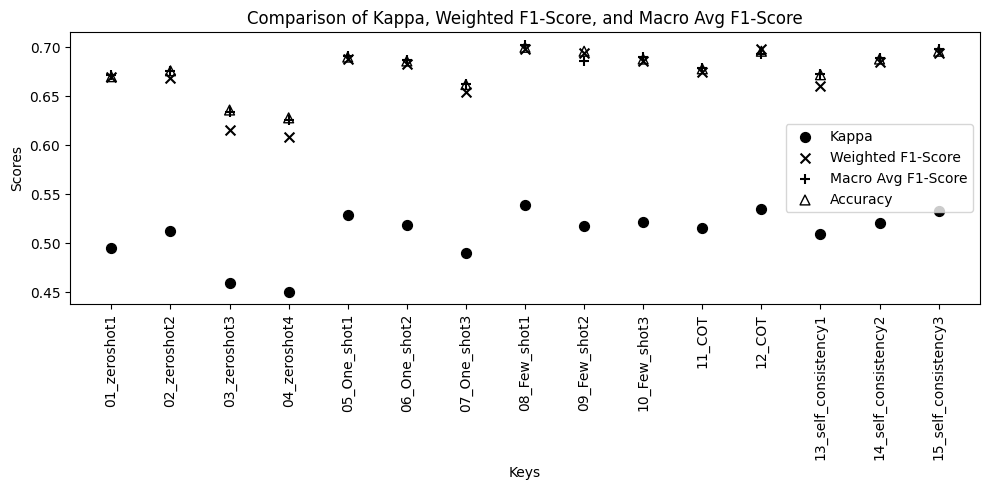

In [ ]:
import matplotlib.pyplot as plt

current_date = datetime.now().strftime('%Y%m%d_%H%M')

# Initialize lists to store the metrics and labels for x-axis
kappa_values = []
weighted_f1_scores = []
macro_avg_f1_scores = []
accuracy_values = []
keys = []

# Loop over the results dictionary to extract metrics
for key, value in results.items():
    if 'kappa' in value and 'classification_report_dict' in value:
        keys.append(key)
        kappa_values.append(value['kappa'])
        weighted_f1_scores.append(value['classification_report_dict']['weighted avg']['f1-score'])
        macro_avg_f1_scores.append(value['classification_report_dict']['macro avg']['f1-score'])
        accuracy_values.append(value['classification_report_dict']['accuracy'])

# Convert keys into positions on the x-axis
x_positions = range(len(keys))

# Plotting
plt.figure(figsize=(10, 5))  # Set the figure size as needed

# Creating a scatter plot for each metric using different markers and line styles
plt.scatter(x_positions, kappa_values, c='black', marker='o', label='Kappa', s=50, facecolors='none')  # Circle
plt.scatter(x_positions, weighted_f1_scores, c='black', marker='x', label='Weighted F1-Score', s=50)  # X marker
plt.scatter(x_positions, macro_avg_f1_scores, c='black', marker='+', label='Macro Avg F1-Score', s=50)  # Plus marker
plt.scatter(x_positions, accuracy_values, marker='^', label='Accuracy', s=50, facecolors='none', edgecolors='black')  # Triangle marker

# Adding labels and title
plt.xlabel('Keys')
plt.ylabel('Scores')
plt.title('Comparison of Kappa, Weighted F1-Score, and Macro Avg F1-Score')

# Adding a legend to differentiate the points with markers
plt.legend()

# Set the position of the x ticks
plt.xticks(x_positions, keys, rotation=90)

# Show the plot
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(output_dir, f"results_{current_date}_metrics_comparison_plot.pdf"), format='pdf', bbox_inches='tight')
plt.savefig(os.path.join(output_dir, f"results_{current_date}_metrics_comparison_plot.png"), format='png', bbox_inches='tight')
plt.savefig(os.path.join(output_dir, f"results_{current_date}_metrics_comparison_plot.eps"), format='eps', bbox_inches='tight')

plt.show()



# Table

In [ ]:
import pandas as pd

# Create a DataFrame from the metrics
df_metrics = pd.DataFrame({
    'Key': keys,
    'Kappa': kappa_values,
    'Weighted F1-Score': weighted_f1_scores,
    'Macro Avg F1-Score': macro_avg_f1_scores,
    'Accuracy': accuracy_values
})

# Display the DataFrame
print(df_metrics)

# Save the DataFrame to a CSV file
df_metrics.to_csv(os.path.join(output_dir, f"results_{current_date}_metrics_table.csv"), index=False)

# If you want to save it to Excel, use:
df_metrics.to_excel(os.path.join(output_dir, f"results_{current_date}_metrics_table.xlsx"), index=False)


                     Key   Kappa  Weighted F1-Score  Macro Avg F1-Score  \
0           01_zeroshot1  0.4954           0.670084            0.671910   
1           02_zeroshot2  0.5125           0.668444            0.676206   
2           03_zeroshot3  0.4599           0.615861            0.633488   
3           04_zeroshot4  0.4505           0.608841            0.626114   
4           05_One_shot1  0.5284           0.687568            0.690668   
5           06_One_shot2  0.5191           0.683117            0.686763   
6           07_One_shot3  0.4905           0.654530            0.662854   
7           08_Few_shot1  0.5388           0.698243            0.702685   
8           09_Few_shot2  0.5174           0.694415            0.685732   
9           10_Few_shot3  0.5217           0.686381            0.690334   
10                11_COT  0.5151           0.674377            0.678695   
11                12_COT  0.5347           0.697869            0.693474   
12  13_self_consistency1 

In [ ]:
# Sort the DataFrame by the 'Kappa' column in descending order
df_metrics_sorted = df_metrics.sort_values('Kappa', ascending=False)

# Display the sorted DataFrame
print(df_metrics_sorted)

                     Key   Kappa  Weighted F1-Score  Macro Avg F1-Score  \
7           08_Few_shot1  0.5388           0.698243            0.702685   
11                12_COT  0.5347           0.697869            0.693474   
14  15_self_consistency3  0.5333           0.693811            0.698077   
4           05_One_shot1  0.5284           0.687568            0.690668   
9           10_Few_shot3  0.5217           0.686381            0.690334   
13  14_self_consistency2  0.5210           0.685395            0.689577   
5           06_One_shot2  0.5191           0.683117            0.686763   
8           09_Few_shot2  0.5174           0.694415            0.685732   
10                11_COT  0.5151           0.674377            0.678695   
1           02_zeroshot2  0.5125           0.668444            0.676206   
12  13_self_consistency1  0.5095           0.660729            0.673149   
0           01_zeroshot1  0.4954           0.670084            0.671910   
6           07_One_shot3 

# Terminate

In [ ]:
from google.colab import runtime
runtime.unassign()